# Predicting Future NBA Hall of Famers using Supervised Machine Learning

SENG 474 - Data Mining

By Mohammad Mohammad (V00923032) & Peter Wilson (V00924887)

### Introduction

This report presents our approach and findings in developing a supervised machine learning model for predicting NBA Hall of Famers. The NBA Hall of Fame is the most prestigious accolade that a basketball player can receive, symbolizing their significant impact on the sport and their lasting legacy. Inductees into the Hall of Fame have left an permanent mark on the National Basketball Association, captivating fans and inspiring younger generations with their exceptional skills and contributions to the game. Legendary figures like Michael Jordan, Wilt Chamberlain, and Hakeem Olajuwon have solidified their places in basketball history through their remarkable achievements.

While some players, such as LeBron James and Stephen Curry, are widely acknowledged as future Hall of Famers due to their remarkable careers and numerous accolades, there are others who may not have yet convinced NBA fans of their potential induction. It is these players who dominate the current league but lack the same level of certainty regarding their Hall of Fame candidacy that motivated us to develop a predictive model. By analyzing the statistics and performance of previously inducted Hall of Famers, we aim to shed light on the likelihood of a player's future induction, based on their career trajectory and accomplishments.

To accomplish this, we have gathered comprehensive datasets that encompass various aspects of player performance and recognition. These datasets include player statistics for each season played from 1950 to 2022, all-star game data spanning the same period, historical Hall of Fame statistics used as training labels, as well as statistics for recipients of the NBA Finals Most Valuable Player (MVP) award and the NBA Season MVP award from 1968 to 2023.

In this report, we will detail our data analysis, feature engineering, and model development process. We will also present the performance and accuracy of our model in predicting Hall of Famers who have already been inducted, as well as its predictions for current players who are yet to retire but may have a strong case for future induction. By leveraging the power of machine learning and historical player data, we aim to provide valuable insights into the potential Hall of Fame careers of current NBA stars and contribute to the ongoing discussions and debates surrounding their legacies.

#### Questions

"Can the predictive accuracy of our Hall of Fame induction model be further improved by incorporating additional features such as player awards, championships won, or team performance metrics?"

This question explores the potential for enhancing the model's performance by considering additional factors that might influence a player's likelihood of being inducted into the Hall of Fame. By incorporating features beyond individual player statistics, such as awards, championships, or team success, we aim to capture a more comprehensive view of a player's overall impact and success. This question is motivated by the desire to explore whether these supplementary features can provide valuable insights and improve the accuracy of our predictive model. It also introduces an interesting and novel aspect to the analysis by expanding beyond individual performance metrics and considering broader contextual factors.

"What is the impact of player longevity on their chances of being inducted into the Hall of Fame, and can it be effectively incorporated into our predictive model?"

This question delves into the relationship between player longevity and Hall of Fame induction. It aims to investigate whether players who have longer careers are more likely to be inducted into the Hall of Fame, and whether this aspect can be effectively integrated into our existing predictive model. By examining the significance of player longevity as a factor in Hall of Fame selection, we can gain insights into the criteria and considerations that influence induction decisions. This question is motivated by the recognition that sustained success and a prolonged impact in the league might be an essential aspect in determining a player's eligibility for the Hall of Fame. Additionally, it explores the potential of incorporating a unique and novel feature related to player longevity into our model, contributing to the ongoing refinement and improvement of the predictive capabilities.

"What are the limitations and potential biases of our current model in predicting Hall of Fame inductees?"

This question aims to critically evaluate the existing predictive model by identifying its limitations and potential biases. By examining the shortcomings of the model, we can gain a better understanding of its accuracy and reliability. Some potential areas to explore could include the model's performance in predicting certain player types or positions, potential biases towards players from certain eras or teams, or limitations in capturing intangible factors such as leadership or impact on the game. Additionally, investigating any inherent biases or assumptions in the data preprocessing and feature engineering stages can help identify areas for improvement and refinement. By addressing these limitations and biases, we can work towards developing a more robust and unbiased model for predicting Hall of Fame inductees.


### Related Work

The prediction of NBA Hall of Famers has long been a popular and intriguing topic within the basketball community. Many analysts and enthusiasts have delved into the task of assessing players' contributions and impact on their teams on a per-game basis to determine their potential for induction. Several articles and online discussions have explored the probability of current players being inducted into the Hall of Fame, offering valuable insights into the factors considered in these predictions.

One notable article published by Scott Davis on [insider.com](https://www.insider.com/nba-players-hall-of-fame-probability-locks-basketball-reference-2022-9#11-kawhi-leonard-11) investigated the Hall of Fame probabilities of active NBA players. The analysis utilized the Hall of Fame probability data from [Basketball-Reference](https://www.basketball-reference.com/leaders/hof_prob.html), which incorporates a wide range of factors and statistical metrics. While the specific data and methodology behind the probabilities are not explicitly disclosed, it is evident that certain performance indicators contribute to the likelihood of induction.

The article highlighted the top 10 players analyzed in terms of their Hall of Fame probability:

| ID | Player Name | Probability |
|----|-------------|------------|
| 1  | Lebron James | 1.0000 |
| 2  | Kevin Durant | 1.0000 |
| 3  | Chris Paul | 1.0000 |
| 4  | Stephen Curry | 1.0000 |
| 5  | James Harden | 0.9999 |
| 6  | Russel Westbrook | 0.9994 |
| 7  | Dwight Howard | 0.9973 |
| 8  | Anthony Davis | 0.9860 |
| 9  | Carmelo Anthony | 0.9842 |
| 10 | Giannis Antetokounmpo | 0.9491 |

While the specific data sources and methodologies used in these probability calculations are not detailed, it is commonly observed that Hall of Famers often exhibit exceptional performances and accomplishments, such as multiple All-Star selections, MVP awards, leading the league in scoring, and other statistical achievements that distinguish them as outliers within the NBA landscape.

Building upon this existing knowledge, our report aims to further investigate and refine the prediction of future NBA Hall of Famers by developing a supervised machine learning model. By leveraging comprehensive datasets encompassing player statistics, All-Star game data, Hall of Fame records, NBA Finals MVP statistics, and NBA Season MVP statistics, we aim to create an optimized model that can provide insights into the potential induction of current players, even before their retirement. Our approach seeks to identify additional features and patterns that contribute to Hall of Fame trajectories and analyzing our model on multiple machine-learning algorithms to find the one that provides that more accurate predictions.

### Data Preparation

The data preprocessing phase plays a crucial role in transforming raw data into a structured and analytically useful format for model development. In order to achieve this objective, we conducted the following steps:

1. **Aggregation of Player Stats**: Leveraging our player stats CSV dataset, we aimed to consolidate each player's career statistics into a single row, representing their total performance in key categories such as field goals made, 2-pointers made, total assists, and more. This aggregation allows us to capture the overall contributions of each player throughout their career.
2. **Calculation of Ratios**: Our project required the utilization of multiple CSV files, necessitating their integration by matching the data based on the unique identifier, **PLAYER_NAME**. Through this process, we combined relevant information from various sources, including player statistics, Hall of Fame data, MVP/Finals MVP records, All-Star selections, and more. This comprehensive dataset forms the foundation for our model training and prediction.
3. **Integration of Multiple CSV Files**: Within our project, we used many different csv files, therefore we had to join them together by **PLAYER_NAME** and include the data we need for our model. The data consistsed of player statistics, hall of fame data, mvp/finals mvp data, all-star selections, and more
4. **Parsing Natural Text into CSV**: Handling the All-Star selections data presented a unique challenge as it was in a natural text format. To overcome this, we developed a custom Python script that converted the text data into a structured comma-separated values (CSV) file, ensuring compatibility and enabling seamless integration into our project workflow.

By executing these preprocessing steps, we successfully transformed the raw data into a refined and unified dataset. This dataset serves as a reliable foundation for training our machine learning model, allowing us to make accurate predictions and draw meaningful conclusions regarding the potential Hall of Fame induction of current NBA players.

### Data Mining Process

Besides the data preperation mentioned previously, the remainder of our data mining aimed to aid our model in accurately predicting Hall of Fame inductees through several steps:

- **Data Transformation**: The aggregated player stats are transformed into a DataFrame called "summary_df" by converting the dictionary into a list of lists and assigning appropriate column names. Additionally, calculated ratios and per-game statistics are added to the DataFrame.
- **Data Enrichment**: The code retrieves information about the number of seasons played, first season, last season, and retired status for each player. The most recent season is determined, and players who are not present in the most recent season are considered retired. These details are added as new columns in the "summary_df" DataFrame.
- **Further Data Preprocessing**: Missing values in the "summary_df" DataFrame are filled with 0 to ensure complete data.
- **Model Building and Evaluation**: A pipeline is created using Scikit-learn's make_pipeline function to incorporate data preprocessing and a machine learning model. Several classification models (Logistic Regression, Random Forest, Decision Tree, Gaussian Naive Bayes, Support Vector Machine, and K-Nearest Neighbors) are instantiated, and their performance is evaluated using the test_model function, which performs data splitting, preprocessing, model fitting, and prediction. The accuracy scores of each model are computed by averaging the results over 50 iterations.
- **Results Presentation**: The average accuracy scores of the models are stored in a DataFrame called "model_accuracies_df" with the corresponding model names.

By following this data mining process, we aim to create a predictive model that can accurately predict Hall of Fame inductees based on their career statistics and other relevant factors.

In [81]:
import pandas as pd
# turn off warnings
import warnings
warnings.filterwarnings('ignore')

First we will view our player statistical data.

In [82]:
import os
player_stats_path = os.path.join('player_stats', 'player_stats.csv')
player_stats = pd.read_csv(player_stats_path)
# drop unnamed columns
player_stats.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
player_stats.head()

,Season,PLAYER_NAME,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1950,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,144.0,516.0,...,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1950,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,102.0,274.0,...,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,1950,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,174.0,499.0,...,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0
3,1950,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,22.0,86.0,...,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0
4,1950,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,21.0,82.0,...,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0


In [83]:
player_stats.columns

Index(['Season', 'PLAYER_NAME', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG',
       'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT',
       'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS'],
      dtype='object')

We now want to create a career summary for each player in the dataset. We will iterate over the player_stats dataframe, adding wanted columns to the dictionary. Note the shooting percentages are not included as they can be calculated afterwards.

In [84]:
to_sum = ['G', 'FG', 'FGA', '3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
player_dict = {}

for row in player_stats.iterrows():
    row = row[1]
    cur = player_dict.get(row['PLAYER_NAME'], [[] for i in range(len(to_sum))])
    for index, col in enumerate(to_sum):
        cur[index].append(row[col])
    player_dict[row['PLAYER_NAME']] = cur

player_dict_new = {}
for player, values in player_dict.items():
    player_dict_new[player] = [sum(values[i]) for i in range(len(values))]

player_dict = player_dict_new
# remember to add max and min salaries at end of loop, and compute percentages
cols = ['PLAYER_NAME'] + to_sum
player_list = [[key] + value for key, value in player_dict.items()]

summary_df = pd.DataFrame(player_list, columns=cols)
summary_df.head()

,PLAYER_NAME,G,FG,FGA,3P,3PA,2P,2PA,FT,FTA,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Curly Armstrong,101.0,216.0,748.0,NaN,NaN,216.0,748.0,228.0,331.0,NaN,NaN,NaN,253.0,NaN,NaN,NaN,314.0,660.0
1,Cliff Barker,149.0,201.0,637.0,NaN,NaN,201.0,637.0,155.0,234.0,NaN,NaN,NaN,294.0,NaN,NaN,NaN,253.0,557.0
2,Leo Barnhorst,416.0,1555.0,4277.0,NaN,NaN,1555.0,4277.0,583.0,870.0,NaN,NaN,NaN,1342.0,NaN,NaN,NaN,1236.0,3693.0
3,Ed Bartels,47.0,68.0,269.0,NaN,NaN,68.0,269.0,62.0,114.0,NaN,NaN,NaN,52.0,NaN,NaN,NaN,112.0,198.0
4,Ralph Beard,126.0,749.0,2046.0,NaN,NaN,749.0,2046.0,508.0,660.0,NaN,NaN,NaN,551.0,NaN,NaN,NaN,228.0,2006.0


Now calculate each players 
- Career Field Goal Percentage
- Career Three-Point Field Goal Percentage
- Career 2-Point Pointer Percentage
- Career Effective Field Goal Percentage
- Career Free Throw Percentage

And their
- Offensive Rebounds Per Game
- Defensive Rebounds Per Game
- Total Rebounds Per Game
- Assists Per Game
- Steals Per Game
- Blocks Per Game
- Turnovers Per Game
- Personal Fouls Per Game
- Points Per Game
- Player Efficiency Rating

In [85]:
summary_df['FG%'] = summary_df['FG'] / summary_df['FGA']
summary_df['3P%'] = summary_df['3P'] / summary_df['3PA']
summary_df['2P%'] = summary_df['2P'] / summary_df['2PA']
summary_df['eFG%'] = (summary_df['FG'] + 0.5 * summary_df['3P']) / summary_df['FGA']
summary_df['FT%'] = summary_df['FT'] / summary_df['FTA']
summary_df['ORBPG'] = summary_df['ORB'] / summary_df['G']
summary_df['DRBPG'] = summary_df['DRB'] / summary_df['G']
summary_df['TRBPG'] = summary_df['TRB'] / summary_df['G']
summary_df['ASTPG'] = summary_df['AST'] / summary_df['G']
summary_df['STLPG'] = summary_df['STL'] / summary_df['G']
summary_df['BLKPG'] = summary_df['BLK'] / summary_df['G']
summary_df['TOVPG'] = summary_df['TOV'] / summary_df['G']
summary_df['PFPG'] = summary_df['PF'] / summary_df['G']
summary_df['PTSPG'] = summary_df['PTS'] / summary_df['G']
# fill null values with 0
summary_df.fillna(0, inplace=True)
# create player efficiency rating PER
summary_df['PER'] = (summary_df['PTS'] + summary_df['TRB'] + summary_df['AST'] + summary_df['STL'] + summary_df['BLK'] - summary_df['TOV']) / summary_df['G']

summary_df.head()

,PLAYER_NAME,G,FG,FGA,3P,3PA,2P,2PA,FT,FTA,...,ORBPG,DRBPG,TRBPG,ASTPG,STLPG,BLKPG,TOVPG,PFPG,PTSPG,PER
0,Curly Armstrong,101.0,216.0,748.0,0.0,0.0,216.0,748.0,228.0,331.0,...,0.0,0.0,0.0,2.504950,0.0,0.0,0.0,3.108911,6.534653,9.039604
1,Cliff Barker,149.0,201.0,637.0,0.0,0.0,201.0,637.0,155.0,234.0,...,0.0,0.0,0.0,1.973154,0.0,0.0,0.0,1.697987,3.738255,5.711409
2,Leo Barnhorst,416.0,1555.0,4277.0,0.0,0.0,1555.0,4277.0,583.0,870.0,...,0.0,0.0,0.0,3.225962,0.0,0.0,0.0,2.971154,8.877404,12.103365
3,Ed Bartels,47.0,68.0,269.0,0.0,0.0,68.0,269.0,62.0,114.0,...,0.0,0.0,0.0,1.106383,0.0,0.0,0.0,2.382979,4.212766,5.319149
4,Ralph Beard,126.0,749.0,2046.0,0.0,0.0,749.0,2046.0,508.0,660.0,...,0.0,0.0,0.0,4.373016,0.0,0.0,0.0,1.809524,15.920635,20.293651


Now add
- Seasons Played
- First Season Played
- Last Season played

In [86]:
player_names = summary_df['PLAYER_NAME']
# get the number of seasons played for each player
seasons_played = []
first_season = []
last_season = []
for player in player_names:
    player_df = player_stats[player_stats['PLAYER_NAME'] == player]
    first_season.append(player_df['Season'].min())
    last_season.append(player_df['Season'].max())
    seasons_played.append(len(player_stats[player_stats['PLAYER_NAME'] == player]))

summary_df['seasons_played'] = seasons_played
summary_df['first_season'] = first_season
summary_df['last_season'] = last_season

Add a column within the datafrane if the player is retired, which is found by if they have statistics in the most recent year

In [87]:
# add retired field
most_recent_season = player_stats['Season'].max()
player_stats_recent = player_stats[player_stats['Season'] == most_recent_season]
recent_players = player_stats_recent['PLAYER_NAME'].unique()
# create a new column in summary df called 'retired' if player is not in recent_players then they are retired
summary_df['retired'] = summary_df['PLAYER_NAME'].apply(lambda x: 1 if x not in recent_players else 0)
summary_df.head()

,PLAYER_NAME,G,FG,FGA,3P,3PA,2P,2PA,FT,FTA,...,STLPG,BLKPG,TOVPG,PFPG,PTSPG,PER,seasons_played,first_season,last_season,retired
0,Curly Armstrong,101.0,216.0,748.0,0.0,0.0,216.0,748.0,228.0,331.0,...,0.0,0.0,0.0,3.108911,6.534653,9.039604,2,1950,1951,1
1,Cliff Barker,149.0,201.0,637.0,0.0,0.0,201.0,637.0,155.0,234.0,...,0.0,0.0,0.0,1.697987,3.738255,5.711409,3,1950,1952,1
2,Leo Barnhorst,416.0,1555.0,4277.0,0.0,0.0,1555.0,4277.0,583.0,870.0,...,0.0,0.0,0.0,2.971154,8.877404,12.103365,7,1950,1954,1
3,Ed Bartels,47.0,68.0,269.0,0.0,0.0,68.0,269.0,62.0,114.0,...,0.0,0.0,0.0,2.382979,4.212766,5.319149,4,1950,1951,1
4,Ralph Beard,126.0,749.0,2046.0,0.0,0.0,749.0,2046.0,508.0,660.0,...,0.0,0.0,0.0,1.809524,15.920635,20.293651,2,1950,1951,1


### Finals and Regular Season MVP datasets
To provide the model with further detail of the players accolades, we include data on which players got finals and regular season MVPs.

In [88]:
# Read the 'finals_mvp.csv' and 'nba_mvps.csv' files
finals_mvps = pd.read_csv("finals_mvp.csv")
regular_mvps = pd.read_csv("nba_mvps.csv")

# Initialize the new columns in summary_df with zeros
summary_df['regular_mvp_count'] = 0
summary_df['finals_mvp_count'] = 0

# Increment the MVP counts based on the corresponding names in finals_mvps and regular_mvps
for index, row in finals_mvps.iterrows():
    player_name = row['PLAYER_NAME']
    summary_df.loc[summary_df['PLAYER_NAME'] == player_name, 'finals_mvp_count'] += 1

for index, row in regular_mvps.iterrows():
    player_name = row['PLAYER_NAME']
    summary_df.loc[summary_df['PLAYER_NAME'] == player_name, 'regular_mvp_count'] += 1

## All Star Dataset

In [89]:
all_stars = pd.read_csv('all_stars_clean.csv')
summary_df = pd.merge(summary_df, all_stars, on='PLAYER_NAME', how='left')
summary_df['All_star_selections'].fillna(0, inplace=True)
summary_df.head()

,PLAYER_NAME,G,FG,FGA,3P,3PA,2P,2PA,FT,FTA,...,PFPG,PTSPG,PER,seasons_played,first_season,last_season,retired,regular_mvp_count,finals_mvp_count,All_star_selections
0,Curly Armstrong,101.0,216.0,748.0,0.0,0.0,216.0,748.0,228.0,331.0,...,3.108911,6.534653,9.039604,2,1950,1951,1,0,0,0.0
1,Cliff Barker,149.0,201.0,637.0,0.0,0.0,201.0,637.0,155.0,234.0,...,1.697987,3.738255,5.711409,3,1950,1952,1,0,0,0.0
2,Leo Barnhorst,416.0,1555.0,4277.0,0.0,0.0,1555.0,4277.0,583.0,870.0,...,2.971154,8.877404,12.103365,7,1950,1954,1,0,0,2.0
3,Ed Bartels,47.0,68.0,269.0,0.0,0.0,68.0,269.0,62.0,114.0,...,2.382979,4.212766,5.319149,4,1950,1951,1,0,0,0.0
4,Ralph Beard,126.0,749.0,2046.0,0.0,0.0,749.0,2046.0,508.0,660.0,...,1.809524,15.920635,20.293651,2,1950,1951,1,0,0,1.0


## Hall of Fame Dataset


In [90]:
hof = pd.read_csv('hof.csv')

# drop other data as player statistics don't contain these values
hof.drop(['All_star_selections','height', 'weight', 'born', 'position'], axis=1, inplace=True)
hof.head()

,PLAYER_NAME,In_Hall_of_fame
0,Larry Foust,0
1,Brad Daugherty,0
2,Bill Laimbeer,0
3,Red Kerr,0
4,Red Rocha,0


Placing labels onto the summary dataframe.

In [91]:
summary_df = summary_df.merge(hof, how='left', on='PLAYER_NAME')
summary_df.fillna(0, inplace=True)
# set All_star_selections and In_Hall_of_fame to int
summary_df['All_star_selections'] = summary_df['All_star_selections'].astype(int)
summary_df['In_Hall_of_fame'] = summary_df['In_Hall_of_fame'].astype(int)

for index, row in summary_df.iterrows():
    if row['In_Hall_of_fame'] > 1:
        summary_df.loc[index, 'In_Hall_of_fame'] = 1

summary_df.head()

,PLAYER_NAME,G,FG,FGA,3P,3PA,2P,2PA,FT,FTA,...,PTSPG,PER,seasons_played,first_season,last_season,retired,regular_mvp_count,finals_mvp_count,All_star_selections,In_Hall_of_fame
0,Curly Armstrong,101.0,216.0,748.0,0.0,0.0,216.0,748.0,228.0,331.0,...,6.534653,9.039604,2,1950,1951,1,0,0,0,0
1,Cliff Barker,149.0,201.0,637.0,0.0,0.0,201.0,637.0,155.0,234.0,...,3.738255,5.711409,3,1950,1952,1,0,0,0,0
2,Leo Barnhorst,416.0,1555.0,4277.0,0.0,0.0,1555.0,4277.0,583.0,870.0,...,8.877404,12.103365,7,1950,1954,1,0,0,2,0
3,Ed Bartels,47.0,68.0,269.0,0.0,0.0,68.0,269.0,62.0,114.0,...,4.212766,5.319149,4,1950,1951,1,0,0,0,0
4,Ralph Beard,126.0,749.0,2046.0,0.0,0.0,749.0,2046.0,508.0,660.0,...,15.920635,20.293651,2,1950,1951,1,0,0,1,0


# Analyze Data

In [92]:
# create a boxplot of PER for players who made the hall of fame
# those who have made an allstar team, and all players in the dataset
import matplotlib.pyplot as plt
import seaborn as sns
hof_data = summary_df[summary_df['In_Hall_of_fame'] == 1]
all_star_data = summary_df[summary_df['All_star_selections'] > 0]
all_data = summary_df

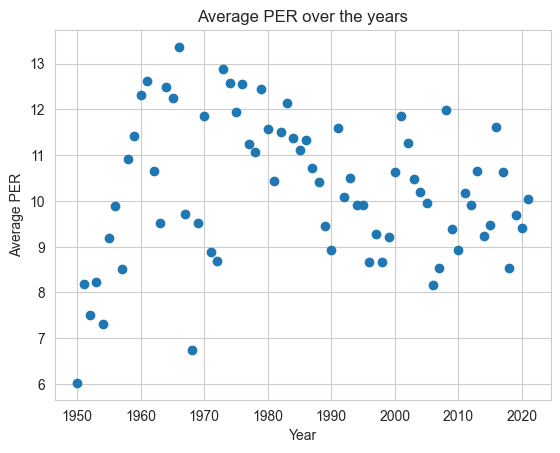

In [93]:
# Creat average PER over the years graph
# for year, use the last season of the player
years = summary_df['last_season'].unique()
years.sort()
# remove most recent year to avoid scewed data
years = years[:-1]
avg_per = []
avg_ptspg = []
for year in years:
    avg_per.append(summary_df[summary_df['last_season'] == year]['PER'].mean())
    avg_ptspg.append(summary_df[summary_df['last_season'] == year]['PTSPG'].mean())

# make a scatter plot of Average per over the years
# ensure the y axis hits 0
plt.scatter(years, avg_per)
plt.title('Average PER over the years')
plt.xlabel('Year')
plt.ylabel('Average PER')
plt.show()

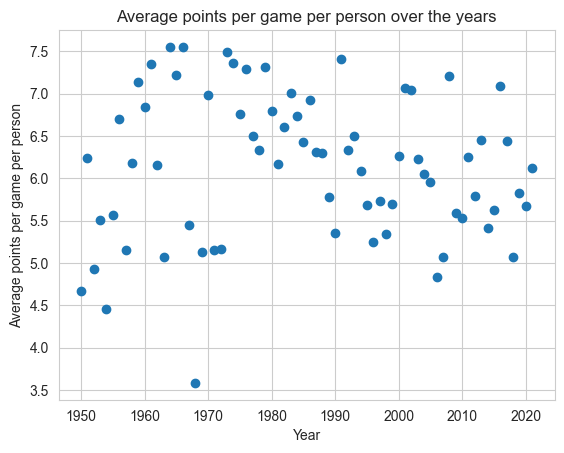

In [94]:
plt.scatter(years, avg_ptspg)
plt.title('Average points per game per person over the years')
plt.xlabel('Year')
plt.ylabel('Average points per game per person')
plt.show()

Create plots to compare all NBA players statistics with those of All-Star players and Hall of Famers

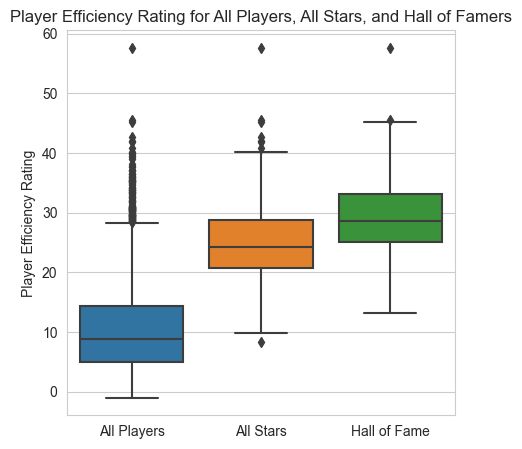

In [95]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(data=[all_data['PER'], all_star_data['PER'], hof_data['PER']], ax=ax)
ax.set_xticklabels(['All Players', 'All Stars', 'Hall of Fame'])
ax.set_ylabel('Player Efficiency Rating')
ax.set_title('Player Efficiency Rating for All Players, All Stars, and Hall of Famers')

plt.show()

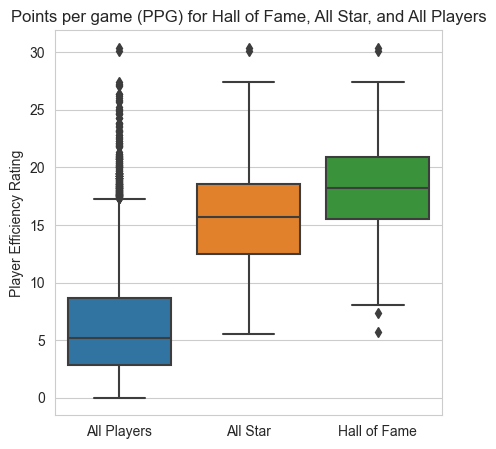

In [96]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(data=[all_data['PTSPG'], all_star_data['PTSPG'], hof_data['PTSPG']], ax=ax)
ax.set_xticklabels(['All Players', 'All Star', 'Hall of Fame'])
ax.set_ylabel('Player Efficiency Rating')
ax.set_title('Points per game (PPG) for Hall of Fame, All Star, and All Players')
plt.show()

# Initial Testing

As most players that play in the NBA don't make it to the hall of fame, we would like to only test on the upper echilon of players. To do this, we will use the Player Efficiency Rating (PER) to determine the top 25% of players and create our test set from this.

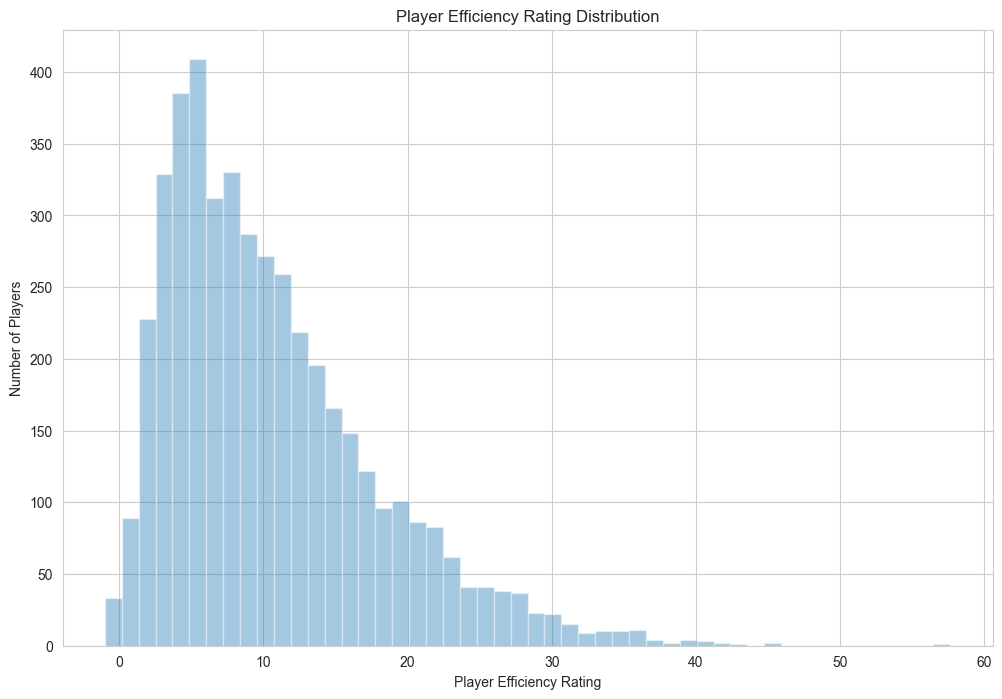

In [97]:
# plot PER distribution
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
sns.distplot(summary_df['PER'], bins=50, kde=False)
plt.xlabel('Player Efficiency Rating')
plt.ylabel('Number of Players')
plt.title('Player Efficiency Rating Distribution')
plt.show()

In [98]:
# get the average PER from all star players
all_star_df = summary_df[summary_df['All_star_selections'] > 0]
all_star_df['PER'].mean()

24.945786536473285

In [99]:
skilled_players = summary_df[summary_df['PER'] >= 20]
# only keep retired players
skilled_players = skilled_players[skilled_players['retired'] == 1]
skilled_players.head()

,PLAYER_NAME,G,FG,FGA,3P,3PA,2P,2PA,FT,FTA,...,PTSPG,PER,seasons_played,first_season,last_season,retired,regular_mvp_count,finals_mvp_count,All_star_selections,In_Hall_of_fame
4,Ralph Beard,126.0,749.0,2046.0,0.0,0.0,749.0,2046.0,508.0,660.0,...,15.920635,20.293651,2,1950,1951,1,0,0,1,0
68,Alex Groza,130.0,1013.0,2136.0,0.0,0.0,1013.0,2136.0,899.0,1189.0,...,22.500000,24.946154,2,1950,1951,1,0,0,1,0
114,Ed Macauley,641.0,3742.0,8589.0,0.0,0.0,3742.0,8589.0,3750.0,4929.0,...,17.525741,20.769111,10,1950,1959,1,0,0,7,1
129,George Mikan,379.0,2961.0,7380.0,0.0,0.0,2961.0,7380.0,2536.0,3235.0,...,22.316623,25.026385,6,1950,1956,1,0,0,4,1
182,Dolph Schayes,996.0,5863.0,15427.0,0.0,0.0,5863.0,15427.0,6712.0,7904.0,...,18.512048,21.596386,15,1950,1964,1,0,0,12,1


In [100]:
# create pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


num_attrs = list(summary_df.drop(['PLAYER_NAME','In_Hall_of_fame','retired'], axis=1).columns)

num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"), 
    StandardScaler())

preprocessing = ColumnTransformer([("num", num_pipeline, num_attrs)])

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def test_model(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    model = make_pipeline(preprocessing, model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [102]:
# create X and y and import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

X = skilled_players.drop(['PLAYER_NAME', 'In_Hall_of_fame', 'retired'], axis=1)
y = skilled_players['In_Hall_of_fame']

Run each model 50 times and use the average accuracy of each to compare them to one-another. We want to run them multiple times so that the accuracy itself is more accurate, which delimits the chance of a model having a "lucky guess".

In [103]:
# run 50 cases of each model and get the average accuracy
models = [LogisticRegression(), RandomForestClassifier(), DecisionTreeClassifier(), GaussianNB(), SVC(), KNeighborsClassifier()]
models_cols = ['LogisticRegression', 'RandomForestClassifier', 'DecisionTreeClassifier', 'GaussianNB', 'SVC', 'KNeighborsClassifier']
model_accuracies = []
for model in models:
    model_accuracy = []
    for i in range(50):
        model_accuracy.append(test_model(model, X, y))
    
    average = sum(model_accuracy) / len(model_accuracy)
    model_accuracies.append(average)

model_accuracies_df = pd.DataFrame(model_accuracies, index=models_cols, columns=['Average Accuracy'])
model_accuracies_df

,Average Accuracy
LogisticRegression,0.877215
RandomForestClassifier,0.871139
DecisionTreeClassifier,0.853418
GaussianNB,0.850886
SVC,0.857215
KNeighborsClassifier,0.824557


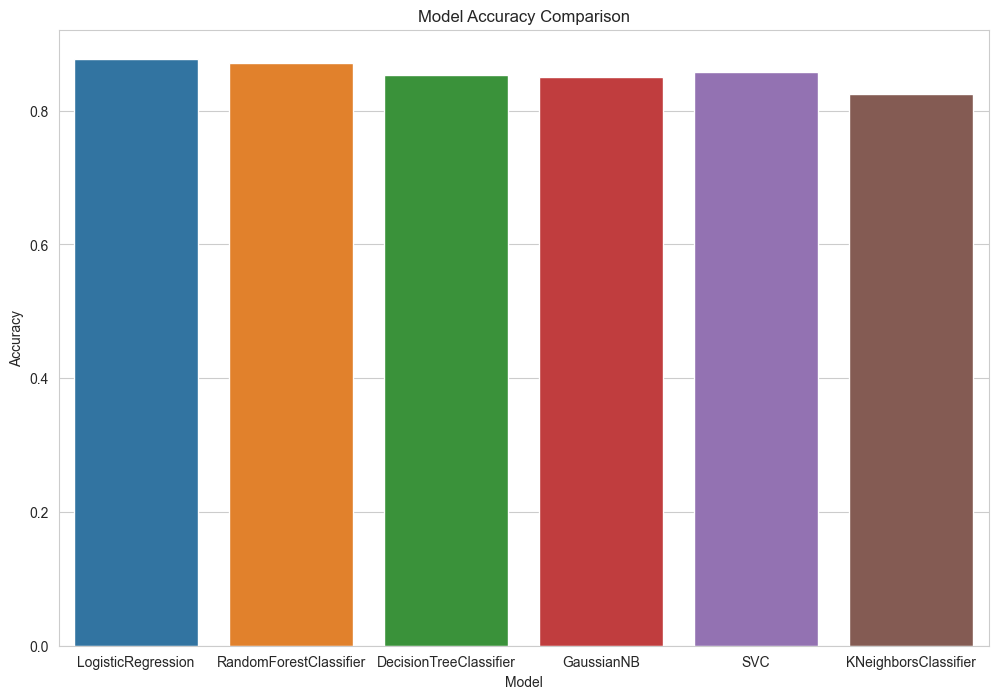

In [104]:
# plot results
plt.figure(figsize=(12, 8))
sns.barplot(x=models_cols, y=model_accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.show()

# Logistic Regression Scored Highest

Now we will do some parameter optimization

In [105]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Create pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('lr', LogisticRegression())
])

# Parameter grid
param_grid = {
    'lr__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'lr__penalty': ['l1', 'l2'],
    'lr__solver': ['liblinear'],
    'lr__class_weight': [None, 'balanced'],
}

# Initialize Grid Search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Assuming X is your feature data and y is your target
X = skilled_players.drop(['PLAYER_NAME', 'In_Hall_of_fame', 'retired'], axis=1)
y = skilled_players['In_Hall_of_fame']

# Fit data to Grid Search
grid_search.fit(X, y)

grid_search.best_params_, grid_search.best_score_

({'lr__C': 0.1,
  'lr__class_weight': None,
  'lr__penalty': 'l1',
  'lr__solver': 'liblinear'},
 0.882667964946446)

In [106]:
# Extract best params
best_params = grid_search.best_params_

# Create a model with the best parameters
best_model = LogisticRegression(C=best_params['lr__C'], 
                                penalty=best_params['lr__penalty'],
                                solver=best_params['lr__solver'],
                                class_weight=best_params['lr__class_weight'])


best_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('lr', best_model)
])
X = skilled_players.drop(['PLAYER_NAME', 'In_Hall_of_fame', 'retired'], axis=1)
y = skilled_players['In_Hall_of_fame']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Fit the new model
best_pipeline.fit(X_train, y_train)

y_pred = best_pipeline.predict(X_test)
accuracy_score(y_test, y_pred)

0.8987341772151899

In [107]:
# Test on whole summary dataset
X = summary_df.drop(['PLAYER_NAME', 'In_Hall_of_fame', 'retired'], axis=1)
y = summary_df['In_Hall_of_fame']
y_pred = best_pipeline.predict(X)
accuracy_score(y, y_pred)

0.9799465240641712

In [108]:
# display confusion matrix
from sklearn.metrics import confusion_matrix
X = skilled_players.drop(['PLAYER_NAME', 'In_Hall_of_fame', 'retired'], axis=1)
y = skilled_players['In_Hall_of_fame']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)

confusion_matrix(list(y_test), list(y_pred))

array([[53,  6],
       [ 7, 13]], dtype=int64)

Here we will create two simple functions that will help us in development. One is show_player_stats, which simply displays all the attributes of a given player. The second is predict_player, which will predict whether the player passed in will (or should) be inducted into the Hall of Fame in the future.

In [109]:
# Predict player
def show_player_stats(player_name):
    player = summary_df[summary_df['PLAYER_NAME'] == player_name]
    return player

def predict_player(player_name):
    player = summary_df[summary_df['PLAYER_NAME'] == player_name]
    player = player.drop(['PLAYER_NAME', 'In_Hall_of_fame', 'retired'], axis=1)
    prediction = best_pipeline.predict(player)
    if int(prediction[0]) == 1:
        return 1
    else:
        return 0
    
predict_player('Trae Young')

1

In [110]:
# lets test players still in the league
players = summary_df[summary_df['retired'] == 0]

players['prediction'] = players['PLAYER_NAME'].apply(predict_player)

# keep only 'PLAYER_NAME' and 'prediction' columns
players = players[['PLAYER_NAME', 'prediction']]

# show players who are predicted to be in the hall of fame
players[players['prediction'] == 1]

,PLAYER_NAME,prediction
2909,Carmelo Anthony,1
2947,LeBron James,1
3003,Dwight Howard,1
3100,Chris Paul,1
3132,LaMarcus Aldridge,1
3224,Kevin Durant,1
3308,Kevin Love,1
3329,Russell Westbrook,1
3347,Stephen Curry,1
3349,DeMar DeRozan,1


Here we will use the predict_player function to predict the Top 10 active players with the high probabilities to be inducted into the Hall of Fame based on the article published by insider.com (mentioned in the introduction). We will see if our model will predict these players successfully.

In [111]:
names = ['LeBron James', 'Kevin Durant', 'Chris Paul', 'Stephen Curry', 'James Harden',
         'Russell Westbrook', 'Dwight Howard', 'Anthony Davis', 'Carmelo Anthony',
         'Giannis Antetokounmpo']

filtered_players = players[players['PLAYER_NAME'].isin(names)]

filtered_players


,PLAYER_NAME,prediction
2909,Carmelo Anthony,1
2947,LeBron James,1
3003,Dwight Howard,1
3100,Chris Paul,1
3224,Kevin Durant,1
3329,Russell Westbrook,1
3347,Stephen Curry,1
3361,James Harden,1
3546,Anthony Davis,1
3610,Giannis Antetokounmpo,1


### Conclusion

In this study, we aimed to develop a predictive model for determining Hall of Fame inductees in the NBA. By leveraging player statistics and various machine learning algorithms, we were able to achieve promising results.

After evaluating multiple classification models, including Logistic Regression, Random Forest, Decision Tree, Gaussian Naive Bayes, Support Vector Machine, and K-Nearest Neighbors, we found that Logistic Regression achieved the highest average accuracy of 87.6%, closely followed by Random Forest with an accuracy of 87.2%. However, given the close proximity of these two accuracies, we did observe a few rare occurrences where the Random Forest model achieved slightly higher accuracy than Logistic Regression. We believe this is due to the inherent randomness in the splitting of data into training and testing sets on these specific occasions. These models demonstrated the ability to effectively differentiate between players who eventually made it to the Hall of Fame and those who did not.

However, it is important to acknowledge the limitations and potential biases of our current model. We should carefully interpret the results considering that our predictions rely solely on player statistics and may not fully capture the intangible aspects that influence Hall of Fame induction, such as leadership qualities, impact on the game, or team success, which are topics that are not possible or extremely difficult to collect data on.

To improve the accuracy and fairness of our model, future research could consider incorporating additional features or factors that better capture the complexities of Hall of Fame selection. This may involve exploring alternative data sources, including subjective evaluations from experts or incorporating advanced player tracking data. Additionally, conducting in-depth analysis of potential biases within the dataset and refining the feature engineering process could help mitigate any existing biases.

Overall, our study presents a valuable framework for predicting Hall of Fame inductees based on player statistics. While our model demonstrates promising accuracy, it should be viewed as a simple tool when compared to the considerations of the selection committee. By continually refining and expanding our approach, we can strive for greater accuracy and fairness in predicting the deserving candidates for the NBA Hall of Fame.